<a href="https://colab.research.google.com/github/SchmetterlingIII/D.T./blob/main/spline_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary of Code
Converting IMU data (gyroscope and accelerometer data), I am trying to make a simple digital twin of the spine which can be used as a posture correction device.

# Next Steps
- quaternions (needs to be done soon). Need to understand the theory and try to properly integrate this. However, for the code I will be using `scipy.spatial.transform.Rotation`rather than writing it all out myself for the sake of efficiency.

Here are some videos for this:
- **https://www.youtube.com/watch?v=hZrBGiWkUyk&t=504s**: *this actually shows a python integration, but quite lax on the theory behind it all*
- https://youtu.be/bKd2lPjl92c?si=yyqcKvoMNcVktlbg
- https://youtu.be/zjMuIxRvygQ?si=b8NkCf_LGxgAJK3Y

---------------

- basic export of data (.csv) and a simple way of scaling (it could be incorporated into a function and then be transferred into an sqlite database)
    - This will later be used as the basis for ML training data

--------------

- improved interpretation of curvature and deviations using clustering ML techniques to help with this project

## Spline Interpolation
*A pretty big note for this is that the constant of 250 (being how many indices are in the list, which can change to make the reading of results more accurate)*


- Get the hospot points plotting
- Segment the spine into positions wrt the inputted linear distances
- Test the functionality of code and debug
- Send off the position, type and intensity of deviance in serial (e.g. serial.bwrite'{3},{STATIC},{HIGH}')
- Debug and iterate with that (and record results with sensors)

--------

- Reducing the accumulation of noise:
    - looking into methods of fixing the rotation issue (like with the issues in the forward kinematics algorithm) so that the resulting curves look like curves
        - look into quaternions
        - look into other approaches to this issue
- Making the curve seem more spine-like:
    - looking into biomechanics to inform my application of B-splines

--------

- Useability:
    - Try to focus on the interface for this project (**in December, when every other part of the project is completely finished off**) so that I can prepare properly for the exhibition, where everyone can use the device (having gone through the calibration phase) and give feedback on the design, wearability and all that


In [ ]:
import serial.tools.list_ports
import string
import serial
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import time
from collections import deque
import numpy as np
from scipy.interpolate import CubicSpline
import scipy
import sys # for debugging specifically

### Serial Reading & Setup

In [ ]:
BAUDRATE = 115200
try:
    # setup for port communication
    ports = serial.tools.list_ports.comports()
    serialInst = serial.Serial()
    portList = [str(i) for i in ports]
    print(portList)

    com = input("Select COM PORT for Arduino: ")

    for i in range(len(portList)):
        if portList[i].startswith("COM" + str(com)):
            SERIAL_PORT = "COM" + str(com)
            print(SERIAL_PORT)

    serialInst.baudrate = BAUDRATE
    serialInst.port = SERIAL_PORT
    serialInst.open()
    print(f"Connected to {SERIAL_PORT} at {BAUDRATE} baud.")

    '''
    initial setup: 'begin program'
    '''

    while True:
        line = serialInst.readline().decode('utf-8') #.strip()
        if line: # if there is data in the readline
            print(f"Arduino: {line}")
        if "Available channels:" in line:
            # extract all after the colon
            channels_part = line.split(":")[-1].strip()
            # parse the comma separated list into on stringed list
            IMU_ID_LIST = [id.strip() for id in channels_part.split(",") if id.strip()]
        if "Number of sensors: " in line:
           ID_NUM = int(line.strip(":")[-3]) # the number of read sensors, last instance is "\n" and so index = -3 is the appropriate index
           #print(ID_NUM)
           IMU_DEQUES = [deque(maxlen=50) for i in range(ID_NUM)]
        if "Waiting for 'begin program' command" in line:
            break

    # get the linear distances for the forward kinematics calculation
    print("INSTRUCTIONS:\nInput the linear distances between your sensors in metres.\nMeasure from lowest to highest.\nI would recommend using a high resolution ruler to reduce drift.\n")
    linear_distances = []
    for i in range(ID_NUM - 1):
        value = float(input(f"{i + 1}: "))
        linear_distances.append(value)

    print("Sending 'begin' command to Arduino")
    serialInst.write(b'begin program') # sent in bytes rather than high level strings
                                       # since it is sent to the compiler

    time.sleep(2)

### Plot Setup

In [ ]:
    # plot setup
    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ## set the points for the animate(i) function
    ## these variables are what are updated (and saves clearing the plot each time)
    scatter = ax.scatter([], [], [], s=50)
    line, = ax.plot([], [], [])
    scatter_hotspot = ax.scatter([], [], [], color='red', s=50)

    ax.set_title("IMU Positions")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")

### Functions & Algorithms
I am here using a forward kinematics algorithm that inputs the matrix of accelerometer data (raw data?) and outputs a kinematic chain that approximates the scaled relationship between the sensors with the inputted linear distances.

**Segmentation Algorithm**: The output of this is such that $[n_0, n_1, ..., n_i]$, where $0 < n < 1$ and $i$ is the length of the list. Using this format, $n_i \equiv 1$ since it is a cumulative algorithm that indicates the percentiles in which these values should occur.

Using this segmentation, I can then send data to the nearest haptic motor if a deviation has occurred.


In [ ]:
    def forward_kinematics(matrix, linear_distances):
        '''
        Computes positions using the IMU data and distances, assuming that the base IMU is at the origin.
        Returns: list of 3D positions

        For later improvements, I will use quaternions to handle the tilt as done in the CHARM Lab device.
        '''

        if not matrix:
            return []

        positions = [np.array([0,0,0])] # centre at the origin, the position vectors are arbitrary as long as they are scaled versions of reality
        t_value_distance = [0]
        cumulative_distance = 0

        for i in range(1, len(matrix)):
            # direction_vector is the difference in the vector direction of the sandwiched positions
            direction_vector_i = np.array(matrix[i])
            direction_vector_j = np.array(matrix[i-1])

            direction_vector = direction_vector_i - direction_vector_j # relative direction
            norm = np.linalg.norm(direction_vector)
            if norm > 1e-10: # error handling incase it produces a small value (and handles for floating point error)
                direction_vector = direction_vector / norm
            else: # error handling
                if i==1:
                    direction_vector = np.array([0,0,1]) # simply translate the vector directly above it
                else:
                    # continue in the same direction as the previous linkage ()
                    prev_pos = positions[-1] - positions[-2]
                    direction_vector = prev_pos / np.linalg.norm(prev_pos)

            distance = linear_distances[i-1]
            link_vector = direction_vector * distance
            new_pos = positions[-1] + link_vector # build from previous position
            positions.append(new_pos)

            cumulative_distance += distance
            t_value_distance.append(cumulative_distance)

        return positions, t_value_distance

    def segmentation_algorithm(linear_distances_list):
        array = np.array(linear_distances_list)
        return np.cumsum(array) / np.sum(array)

    def interquartile_mean_calculation(poor_posture_list_input):
        list_input = np.array(poor_posture_list_input)
        n = len(list_input)

        if n == 0:
            return np.nan # an empty list
        if n < 4: # not enough elements for any meaningful IQR
            return np.mean(list_input)

        list_input.sort()
        n_upper = int(n * 0.75)
        n_lower = int(n * 0.25)

        interquartile_list = list_input[n_lower:n_upper]

        if interquartile_list.size == 0: # incase an unexpected error occurred
            return np.mean(list_input)

        interquartile_mean = np.mean(interquartile_list)
        return interquartile_mean

### Databases & .csv Files
It will be stored in a SQLite database

### Data Plotting

The previous runs of this had a monolithic `animate(i)` function which made this impossible to debug.

Therefore:
- develop a class based structure
- test this code in a separate file with pseudo data
- there is an error with the runtime of this with 5 sensors

All of these makes the implementation of ML (like `k-mean clustering` for the calibration phase) much harder to implement.

There should also be ways of quantifying the improvements of this code but I am not sure currently.

In [ ]:
'''
I do not know how to implement the state variables across both classes in any meaningful way; this will be a problem that I will solve later.
'''

class Spine:
    def __init__(self, raw_data, num_sensors):
        '''
        This holds the raw information of the digital twin except for any analysis.
        The output of this is the function of the spine at a given point (and the list of its positions for previous timesteps) but nothing else.
        Here there will be the storage into the database (SQLite) but I need to understand where this is actually stored and how to restore it after different runs of this code.
        '''

        self.raw_data = raw_data
        self.num_sensors = num_sensors
        self.poor_posture_start_time = None

        return None

    def data_cleaning(self):
        return self.

    def interpolated_function(self):
        '''
        This should also update the deque list (and how it is stored within the code)
        Also have qualities such as 'self.position_vectors' and a specific understanding of how many vectors to have and where they all go handled nicely
        '''
        return interpolated_function

    def database_storage(self):
        '''
        Call the database here and upload the raw data of the spine here and see the flaws in my recreation.
        Raw data is the only important aspect here so this should be quite a simple endeavour.

        The only issue here is the rate at which this function is called since there is now a real issue of threading and the rate of calling a function exceeding the rate it actually runs.
        How do I overcome this?
        '''




For the function `calibration_dataset(self)`, I am not sure whether this data should be raw or the already filtered curvatures from the `Spine` class. The filtered ones may be better since I could just improve the previous algorithm (using quaternions and filters to reduce the drift from the accelerometers) which would just save time.

I also want to display this output as a nodal graph (and cluster the data in different colours for each of the IMU segments) to try to visualise what this intuitively means.

For the function `calibrated_curvature(self)`, I am struggling to think of an appropriate output from this function given that I would have calculated the statistical distribution from the initial dataset but now what should I do with it. I want a method that is not computationally expensive (I don't want to calculate the range from which the data could fall into for each step). This will be a problem to solve, but I do not know when.

In [ ]:
class CurvatureAnalysis:
    def __init__(self):
        self.baseline_curvature = None
        self.calibration_duration = 30
        self.calibration_dataset = None

    def calibration_dataset(self):
        '''
        This collects all the curvatures from the sensors during the calibration period into a dataset in which k-means clustering can take place.
        '''
        return self.calibration_dataset

    def calibrated_curvature(self):
        '''
        Using the dataset, k-means clustering will take place such that a measure of deviation from this distribution can be assertained.
        My intention would be further for this data to be presented (not as a digital twin) to see whether more information can be ascertained.
        What would be returned from this? The ranges of data this can fall between to not be an anomaly?
        '''


In [ ]:

    baseline_curvature = None
    is_calibrating = True
    calibration_start_time = time.time()
    calibration_duration = 3 # seconds; increase this time for actual deployment. It will be low for testing.
    calibration_curvature_array = [] # use np.array or something similar
    calibration_standard_deviation = [] # standard deviation of the points on the thing

    poor_posture_list = [] # contains the arrays of all the deviated postures
    poor_posture_start_time = None # storing the time.time() when poor posture starts
    threshold_time = 0.1 # seconds; it will increase again after testing

    plot_radius = sum(linear_distances) * 1.125 # a scaled form of the plot so that I can see the results more clearly

    linear_distance_percentiles = segmentation_algorithm(linear_distances) # positions of the linear distance percentiles
    print(f"\nCALIBRATION PHASE.\nDURATION: {calibration_duration}\n\n")
    def animate(i):
        # making these values global in this function will reduce the chance of errors
        global baseline_curvature, is_calibrating, calibration_start_time, calibration_curvature_array
        global curvature_standard_deviation, poor_posture_list, poor_posture_start_time

        try:
            """DATA ACQUISITION"""
            IMU_FULL_CHANNEL_DATA = serialInst.readline().decode('utf-8').strip().split(",")
            IMU_ID = int(IMU_FULL_CHANNEL_DATA[-1]) # the ID prescribed by the sensor number
            IMU_DATA = [float(acc) for acc in IMU_FULL_CHANNEL_DATA[:3]] # ONLY APPENDING ACCELERATION, TO CHANGE WHEN DOING KALMAN FILTERING
            IMU_DATA_NORM = IMU_DATA/np.linalg.norm(IMU_DATA)

            try:
                target_IMU_index = IMU_ID_LIST.index(str(IMU_ID)) # str(IMU_ID) since IMU_ID_LIST is a string
                IMU_DEQUES[target_IMU_index].append(IMU_DATA_NORM)

            except ValueError:
                print(f"Warning: Recieved data from unknown data channel @ ID:{IMU_ID}")

            if all(IMU_DEQUES):# when there is data in all of the deques i.e. all the sensors are outputting data
                IMU_NORMALISED_MATRIX = [dque[-1] for dque in IMU_DEQUES]
                positions, t_values = forward_kinematics(IMU_NORMALISED_MATRIX)
                IMU_POSITIONS = np.array(positions)

                x = IMU_POSITIONS[:, 0]
                y = IMU_POSITIONS[:, 1]
                z = IMU_POSITIONS[:, 2]

                # below is an example of a global cubic spline which will be easier to compute.
                # I will experiment later with other forms of parametric equations (e.g. constrained b-splines) but the simplicity of this will help with better optimisation
                xc = CubicSpline(t_values, x)
                yc = CubicSpline(t_values, y)
                zc = CubicSpline(t_values, z)

                plot_t = np.linspace(min(t_values), max(t_values), 250) # t_values to for a smooth plot

                curvature_list = [] # the list for values of $\kappa$ that updates for each instance of the spline curve
                for i in range(len(plot_t)):
                    r = (xc(plot_t[i], 0), yc(plot_t[i], 0), zc(plot_t[i], 0))
                    r_prime = (xc(plot_t[i], 1), yc(plot_t[i], 1), zc(plot_t[i], 1))
                    r_double_prime = (xc(plot_t[i], 2), yc(plot_t[i], 2), zc(plot_t[i], 2))

                    kappa = (np.linalg.norm(np.cross(r_prime, r_double_prime)))/(np.linalg.norm(r_prime)**3)
                    curvature_list.append(kappa)

                curvature_instance_array = np.array(curvature_list)

                # Now I will apply the state conditions
                """CALIBRATION PHASE"""
                if is_calibrating is True:
                    # collect data through the list quantity outside of the loop
                    calibration_curvature_array.append(curvature_instance_array)
                    if (time.time() - calibration_start_time) > calibration_duration:
                        # do the processing: simple test will just include the mean of the results but later ones will research into other methods
                        # like using a mix between the standard deviation, rolling mean
                        """
                        For future models, I will have the calibration phase be where the user moves to (a) a comfortable posititon, (b) defined positions that would be displayed (such as asking the user to tilt forward (there will be a diagam of what to do))
                        From this, I can develop an ML model (or just do more research into anatomical landmarks) and have a personalised "shape" for the user's spine; even if they have spinal deformities -- given the amount of input data from this calibration phase.
                        Then other forms of means can be applied (to be )
                        """
                        # mean value stored over this timestep (which doesn't actually need to be defined)
                        baseline_curvature = np.mean(calibration_curvature_array, axis=0)

                        # define the standard deviation of this distribution
                        curvature_standard_deviation = np.std(calibration_curvature_array, axis=0)

                        # leave this state
                        print("\nNOW EXITING CALIBRATION PHASE\n\n")
                        is_calibrating = False
                else:
                    # begin the monitoring mode
                    # compare the calibration code things, checking if the difference is within the standard deviation of each of the curvatures
                    if any((curvature_instance_array - baseline_curvature) > 1.5 * curvature_standard_deviation): # if there is a single instance of a deviation
                        """Poor posture has started. Start storing the indices of where the deviances have occurred and use this for later plotting."""
                        """The positions will also say where a signal should be sent along the spine"""

                        """
                        list structure that is 0 unless at the indicies where the baseline_curvature has exceeded
                        Then it will show by how much it has exceeded this level (the difference)
                        e.g. np.array([0,0,0,0,1,1.2,1.9,2.1,1.1,0.75,0.5,0,0,0,0,0])
                        It must retain the total length of the curvature_instance_array (as this index will be important)
                        """

                        print("THERE HAS BEEN DETECTED POOR POSTURE.")
                        deviation = (curvature_instance_array - baseline_curvature)
                        deviated_posture_instance = np.where((deviation > 1.5 * curvature_standard_deviation), deviation, 0)

                        poor_posture_list.append(deviated_posture_instance)

                        if poor_posture_start_time == None:
                            poor_posture_start_time = time.time()


                        elif (time.time() - poor_posture_start_time) > threshold_time:
                            """
                            There is now sustained poor posture, therefore model a distribution of the deviances of the posture. Depending on the threshold time, I could include a recency bias.
                            Send a signal to serial indicating the position of this poor posture and where the average of this is.
                            The signal processing (a dedicated function for ease) will send out:
                                1. The sensor(s) which is/are nearest to the deviations
                                2. The intensity of the haptic motor signal (from the distribution of peaks (should use deques for this aspect with the recency bias))
                                3. Tackle the issue of n-number deviances
                                4. Share this to the serial in this format: "serial.write(bf'Curve, {signal_response[0]}, {signal_response[1]}')"
                                5. Use the indices to plot the points in 3D space
                            """
                            poor_posture_list_numpy = np.array(poor_posture_list)
                            average_deviated_posture = np.array([interquartile_mean_calculation(poor_posture_list_numpy[:,i]) for i in range(len(poor_posture_list_numpy[0]))]) # i.e. for i in range({the length of each of the lists})

                            """
                            With this initial test, I will find the local maxima for the interpolated graph (using cubic interpolation; but will have this graph displayed for debugging)
                            """
                            deviated_graph_range = average_deviated_posture - baseline_curvature
                            """
                            # This may produce errors since the length of this list does not equate the thing that I will index it against
                            deviated_graph_domain = np.arange(len(deviated_graph_range))

                            # interpolate this into a function
                            deviated_graph_function = CubicSpline(deviated_graph_domain, deviated_graph_range)

                            # find the local maximum (and its index) for this

                            deviated_graph_domain_refined = np.linspace(0, len(deviated_graph_range), (len(deviated_graph_range) * 5)) # refined to approach the dx of finding the derivatives anyways
                            deviated_graph_range_refined = deviated_graph_function(deviated_graph_domain_refined)
                            """
                            peak_indices, dictionary_properties = scipy.signal.find_peaks(deviated_graph_range, prominence=None) # adjust the prominence values throughout through the test
                            # this can then be used to plot the position of the deviaiton (as a hotspot on the thing)
                            """
                            These indices are now the same for my hotspot which can be plotted as positions (which is fun and cool)
                            """
                            ## later, break down the fucntion into the points of the linear distances and get that all sorted out
                            """
                            Finding the linear distance thing is easy since I can just use the ratios between the distances and find the indices of them
                            Once I have done this bit I am free since I can print it out a red dot for where the deviation is and then be free
                            the place of the sensor can then be outputted from it
                            """
                            peak_incides_percentile = peak_indices / len(deviated_graph_range)
                            sensor_indices = []

                            for each_index in peak_incides_percentile:
                                # the argument where min(each_index - linear_distance_percentiles), i.e. the index in linear_distance_percentiles that this happens (because this is then the sensor that this happens in )
                                dist = np.abs(linear_distance_percentiles - each_index)
                                sensor_index = dist.argmin()
                                sensor_indices.append(sensor_index)

                            serialInst.write(f'DEVIATED_CURVE, {str(sensor_indices)}, [INTENSITY_VALUE]'.encode()) # there have been errors with the output of the sensor_indices not being a string

                            scatter_hotspot._offsets3d = (xc(plot_t[peak_indices]), yc(plot_t[peak_indices]), zc(plot_t[peak_indices]))
                            # the output to the serial will be a numpy array

                            return scatter, line, scatter_hotspot

                    else:
                        '''GOOD POSTURE'''
                        poor_posture_list = []
                        poor_posture_start_time = None
                        scatter_hotspot._offsets3d = ([], [], [])

                """PLOTTING LOGIC"""
                # Logic to allow the spline to be centred in frame (for easy visibility)
                centre_point = np.mean(IMU_POSITIONS, axis=0) # axis=0 is working along the column, axis=1 works along rows (especially with bigger matrices)

                ax.set_xlim(centre_point[0] - plot_radius, centre_point[0] + plot_radius)
                ax.set_ylim(centre_point[1] - plot_radius, centre_point[1] + plot_radius)
                ax.set_zlim(centre_point[2] - plot_radius, centre_point[2] + plot_radius)

                ## update stored variables ("scatter" + "line,") with new positions
                ## more efficient than ax.clear()

                scatter._offsets3d = (IMU_POSITIONS[:, 0], IMU_POSITIONS[:, 1], IMU_POSITIONS[:, 2]) # plots all x, y, z coordinates: regardless of number of rows in this matrix

                """
                Now plot the position
                """
                # line.set_data(IMU_POSITIONS[:, :2].T) # takes in (x,y) values of the points (matplotlib used to only do 2D stuff)
                # line.set_3d_properties(IMU_POSITIONS[:, 2]) # add the z-coordinate (3D space) on top of this

                line.set_data(xc(plot_t), yc(plot_t))
                line.set_3d_properties(zc(plot_t))
                ax.grid()

                ax2.clear()
                ax2.plot(plot_t, curvature_list)
                # print(max(curvature_list))
                # print(f"Current Avg: {np.mean(curvature_list)}")
                ax2.set_title("Curvature Graph")
                ax2.grid()

                """CALL THE .CSV FUNCTION/SQLITE DATA HERE TO STORE ALL THE DATA IN THE WAY THAT IS NECESSARY"""

        except (ValueError, IndexError) as e:
            print(f"Serial line error: {e}")
            # pass
            return scatter, line, scatter_hotspot

        return scatter, line, scatter_hotspot

    # PLOTTING DISPLAY
    anim = FuncAnimation(fig, animate, cache_frame_data=False, interval=100, blit=True) # blitting only draws the dynamic aspects of the plot
                                                                                        # rather than redrawing e.g. '{Title}' at each timestep
                                                                                        # this save computation
    ax.set_box_aspect([1,1,1])
    ax.set_proj_type('ortho')
    plt.tight_layout()
    plt.show()

### Exceptions
Although quite simple, this has helped to quickly identify bugs in the code and solve them.

In [ ]:
except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
            line_number = exc_traceback.tb_lineno
                print(f"ERROR: {e}, line {line_number}")

# References (& Notes)

The `find_peaks` function from `scipy` has an attribute called `prominence` which was a new concept for me in signal processing.

The essence of it is (centred around different local maxima of a function) and sees the distance from the two tangents (that are slightly offset from the peaks) to their lowest point. That distance in amplitude indicates the prominence of the signal and is used in signal processing to *smooth-off* noise.

Lines 122-132:

Below is the code excerpt

In [ ]:
elif (time.time() - poor_posture_start_time) > threshold_time:
    """
    There is now sustained poor posture, therefore model a distribution of the deviances of the posture. Depending on the threshold time, I could include a recency bias.
    Send a signal to serial indicating the position of this poor posture and where the average of this is.
    The signal processing (a dedicated function for ease) will send out:
        1. The sensor(s) which is/are nearest to the deviations
        2. The intensity of the haptic motor signal (from the distribution of peaks (should use deques for this aspect with the recency bias))
        3. Tackle the issue of n-number deviances
        4. Share this to the serial in this format: "serial.write(bf'Curve, {signal_response[0]}, {signal_response[1]}')"
        5. Use the indices to plot the points in 3D space
    """

It has been taking me much longer to solve this issue that I have since there are multiple overlapping requirements that need to be handled by some helper functions. Therefore, I will take the time to explain my thinking process for this and include links to subsequent files in this repo the explores the derivation for this solution in more depth.

#### Rolling Mean
For the duration of the *deviation* there will be a distribution of different functions (deviation against postition along spine graph) for each instance of this. To aggregate this, I would like to make an algorithm to make a mean that can account for anomalies (I don't think any of the measures of central tendency accounts for this specific goal that I have).

Below will explore this clearer:
$$
\mathrm{devation\_array\_0} = \begin{bmatrix}i_0 & i_1 & i_2 & ... & i_n\end{bmatrix} \\\

\\
\mathrm{devation\_array\_1} = \begin{bmatrix}j_0 & j_1 & j_2 & ... & j_n\end{bmatrix} \\\

\\
... \\\

\\
\mathrm{devation\_array\_n} = \begin{bmatrix}k_0 & k_1 & k_2 & ... & k_n\end{bmatrix}
$$

For each column in this large matrix, I would like to create an average of the results to output a final array which can be approximated by a single function:$\mathrm{aggregated\_devation\_array} = \begin{bmatrix}\lambda_0 & \lambda_1 & \lambda_2 & ... & \lambda_n\end{bmatrix}$, which approximates to $f(x)$.

However, if there were anomalous extremes in this (the aggregation of noise in the sensors for examples or just a random spike) I wouldn't want this affecting, drastically, the distribution of the points and deviation.

Therefore, this algorithm will occur with an example:

Let's define the list:
$$\gamma = [3,5,6,9,13,15,1700]$$
The arithmetic mean of this distribution is: $$\frac{1751}{7} \approx 250$$
If using groups of length 4 however, the result differ: $$\frac{\frac{3+5+6+9}{4} + \frac{5+6+9+13}{4} + \frac{6+9+13+15}{4} + \frac{9+13+15+1700}{4}}{4}\\\
\\=\frac{459}{4} \approx 115$$

I am not sure why this result arises but trying to test and define this algorithm will help with my application in code.

A better approach for summarising the values of the $n$-th index could be centering the values around the median value and then finding the interquartile mean. From this, it would help to remove the anomalous values: however, through the testing below it could be shown that this approach actually removes important areas (higher values than the mean doesn't always mean anomalous!)

In [ ]:
import numpy as np


"""
List Setup
"""

# use a random list of varying degrees as the base test
array_1 = np.random.uniform(0, 100, 200)
array_1 = np.concatenate([array_1, np.random.uniform(0,100,5)])

# then use a similar list but with a very large values placed as anomalies
anomalies = np.random.uniform(10000,25000,5)
array_2 = np.concatenate([array_1, anomalies])

# finally use a fluctuating list

# try to plot each of these values against each other and choose the best appraoch to this (with my data)

def listing_method(n, list_input):
    """
    There is an error that if I input a value of "n" larger than len(list_input) after one error has occurred, it will just default to time_series_mean == 0.000
    I do not know how to to debug that.
    """
    setup = True
    while setup:
        if n > len(list_input) or n < 1 or not isinstance(n, int):
            try:
                n = int(input(f"Enter a value for n in range 1 and {len(list_input)}: "))
            except ValueError:
                print("Please enter an integer.")
        else:
            setup = False  # exit only when n is valid


    """
    Input the algorithm for this.
    """
    list_input = np.array(list_input)
    subdivided_lists = [list_input[i:(i+n)] for i in range((len(list_input)) - n + 1)]
    subdivided_list_mean = [sum(subdivided_lists[i])/n for i in range(len(subdivided_lists))]
    time_series_mean = np.mean(subdivided_list_mean)
    return time_series_mean

def interquartile_mean_calculation(poor_posture_list_input):
    list_input = np.array(poor_posture_list_input)
    n = len(list_input)

    if n == 0:
        return np.nan # an empty list
    if n < 4: # not enough elements for any meaningful IQR
        return np.mean(list_input)

    list_input.sort()
    n_upper = int(n * 0.75)
    n_lower = int(n * 0.25)

    interquartile_list = list_input[n_lower:n_upper]

    if interquartile_list.size == 0: # incase an unexpected error occurred
        return np.mean(list_input)

    interquartile_mean = np.mean(interquartile_list)
    return interquartile_mean

n = 15  # how can I numerically find the best value for n, given the list size?
i = listing_method(n, array_1)
j = listing_method(n, array_2)
k = interquartile_mean(array_1)
p = interquartile_mean(array_2)

med1 = np.median(array_1)
med2 = np.median(array_2)

print(f"listing, array_1: {i}")
print(f"listing, array_2: {j}")
print(f"IQM, array_1: {k}")
print(f"IQM, array_2: {p}")
print(f"Median, array_1: {med1}\nMedian, array_2: {med2}")

listing, array_1: 48.871021810374685
listing, array_2: 136.70835019532615
IQM, array_1: 46.50263108386841
IQM, array_2: 47.70528409743101
Median, array_1: 45.86740841831052
Median, array_2: 46.51556502432626


From running this, the interquartile method is significantly better since the runtime is much, much lower (and this will have to run in real time).

I will look into ways of optimising this algorithm but since it is dependent on length of the list (of size n) then accuracy will be lost through this process.

I'll try to run other similar methods as well to check but the interquartile method is the best (and I will adjust the size of that window (10-90 or 40-60 depending on what I am looking for) in the actual code).

I am now interested in how I can find the optimal value for this (if I run some tests) to see what would actually be the best window size - if such a thing exists.

In [ ]:
import numpy as np

lis = [9,9,9,8,8]
l = np.array(lis)
q = np.array(l)
print(l)
print(q)


[9 9 9 8 8]
[9 9 9 8 8]


## Further Notes
*Most of these are minor and will not require you to read in full detail. Just some debugging notes that I thought were quite interesting.*

In [ ]:
>>> %Run -c $EDITOR_CONTENT
['COM4 - USB Serial Device (COM4)']
Select COM PORT for Arduino: 4
COM4
Connected to COM4 at 115200 baud.
Arduino: Scanning for MPU6050 sensors...

Arduino: MPU6050 found on channel: 1

Arduino: MPU6050 found on channel: 2

Arduino: MPU6050 found on channel: 7

Arduino: Scan complete.

Arduino: Number of sensors: 3

Arduino: Waiting for 'begin program' command from Python...

INSTRUCTIONS:
Input the linear distances between your sensors in metres.
Measure from lowest to highest.
I would recommend using a high resolution ruler to reduce drift.

1: 0.8
2: 1.2
Sending 'begin' command to Arduino
[0, np.float64(1.7002608188978967), np.float64(2.3116596642251377)]
[0, np.float64(1.7002133388889717), np.float64(2.310336879220833)]
[0, np.float64(1.7012085380953463), np.float64(2.308722202272333)]
[0, np.float64(1.7012085380953463), np.float64(2.3078122623177437)]
[0, np.float64(1.700975555042097), np.float64(2.3067901580239405)]
[0, np.float64(1.701909188664967), np.float64(2.306863843345119)]
[0, np.float64(1.701909188664967), np.float64(2.3137630890144245)]
[0, np.float64(1.702833266797377), np.float64(2.3189506290049837)]
[0, np.float64(1.7022670545750367), np.float64(2.3189851094288194)]
[0, np.float64(1.7022670545750367), np.float64(2.3197120422813353)]
[0, np.float64(1.7018079144171796), np.float64(2.3162820432259226)]
[0, np.float64(1.7016693695090244), np.float64(2.3157243373491117)]
[0, np.float64(1.7016693695090244), np.float64(2.3078162928124573)]
[0, np.float64(1.7031701176773655), np.float64(2.310697561458317)]
[0, np.float64(1.7019280643226833), np.float64(2.3130991998450496)]
[0, np.float64(1.7019280643226833), np.float64(2.305268296448368)]
[0, np.float64(1.6982442680490895), np.float64(2.2956412728149207)]
[0, np.float64(1.6995619850557635), np.float64(2.2942051177066367)]
[0, np.float64(1.6995619850557635), np.float64(2.308272761960484)]
[0, np.float64(1.7013631971098364), np.float64(2.315276393314129)]
[0, np.float64(1.7012590350387387), np.float64(2.3144619450534734)]
[0, np.float64(1.7012590350387387), np.float64(2.309990439743061)]
[0, np.float64(1.7003392801521715), np.float64(2.306417449522973)]
[0, np.float64(1.700181486565279), np.float64(2.3083774509117894)]
[0, np.float64(1.700181486565279), np.float64(2.31805580077557)]
[0, np.float64(1.700090090869896), np.float64(2.3181018400501943)]
[0, np.float64(1.6995748638604637), np.float64(2.31665525623587)]
[0, np.float64(1.6995748638604637), np.float64(2.3068718581907244)]
[0, np.float64(1.700541928498939), np.float64(2.3088376953349776)]
[0, np.float64(1.7010307947650332), np.float64(2.3088331324525146)]
[0, np.float64(1.7010307947650332), np.float64(2.313279418420447)]
[0, np.float64(1.7017253367062817), np.float64(2.315697715965786)]
[0, np.float64(1.7032315301025813), np.float64(2.315692481754368)]
[0, np.float64(1.7032315301025813), np.float64(2.321673792137373)]
[0, np.float64(1.7046142484593476), np.float64(2.324019445729593)]
[0, np.float64(1.7027125342509335), np.float64(2.3251810408519766)]
[0, np.float64(1.7027125342509335), np.float64(2.304374193003093)]
[0, np.float64(1.6976924480732087), np.float64(2.291484471398044)]
[0, np.float64(1.69773470321328), np.float64(2.2897254671472433)]
[0, np.float64(1.69773470321328), np.float64(2.297543389797544)]
[0, np.float64(1.7000340992390177), np.float64(2.3046718639489603)]
[0, np.float64(1.7008479670077348), np.float64(2.3063677292940192)]
[0, np.float64(1.7008479670077348), np.float64(2.3095234318034144)]
[0, np.float64(1.7021149780064502), np.float64(2.311154797468209)]
[0, np.float64(1.701102990754899), np.float64(2.3097944940746196)]
[0, np.float64(1.701102990754899), np.float64(2.303884237533528)]
[0, np.float64(1.7005890703708832), np.float64(2.3030175851807)]
[0, np.float64(1.7010061665217378), np.float64(2.3031357329933293)]
[0, np.float64(1.7010061665217378), np.float64(2.3101561179804833)]
[0, np.float64(1.6991151509685518), np.float64(2.3063518797232567)]
[0, np.float64(1.6991208061394103), np.float64(2.305761581443791)]
[0, np.float64(1.6991208061394103), np.float64(2.297433219940695)]
[0, np.float64(1.6999222298830556), np.float64(2.300102736432799)]
[0, np.float64(1.70087860961743), np.float64(2.3018189045742217)]
[0, np.float64(1.70087860961743), np.float64(2.3059987411785454)]
[0, np.float64(1.699957599091164), np.float64(2.304180363482735)]
[0, np.float64(1.698605648331159), np.float64(2.304345601443344)]
[0, np.float64(1.698605648331159), np.float64(2.3107568337572704)]
[0, np.float64(1.7007320401912194), np.float64(2.3138670728742636)]
[0, np.float64(1.7007649037896928), np.float64(2.3130403268258273)]
[0, np.float64(1.7007649037896928), np.float64(2.3044703104956836)]
[0, np.float64(1.7003930641844198), np.float64(2.303367330841352)]
[0, np.float64(1.7013420100586318), np.float64(2.3032454264035036)]
[0, np.float64(1.7013420100586318), np.float64(2.304369305472821)]
[0, np.float64(1.7002908850836524), np.float64(2.3023336367857694)]
[0, np.float64(1.700131611508251), np.float64(2.3019850345122306)]
[0, np.float64(1.700131611508251), np.float64(2.3016486241475644)]
[0, np.float64(1.7002015769674175), np.float64(2.302406113744078)]
[0, np.float64(1.7013173853798462), np.float64(2.3026547916354394)]
[0, np.float64(1.7013173853798462), np.float64(2.3066929305117467)]
[0, np.float64(1.7020247920575777), np.float64(2.308667399416257)]
[0, np.float64(1.7002810645081592), np.float64(2.307420286937357)]
[0, np.float64(1.7002810645081592), np.float64(2.30575344175153)]

>>>


**Above**: Truncated version of the output, but the `t_values` does not equal `[0, linear_distances[0], (linear_distances[0] + linear_distances[1])]`. This is quite confusing and will require debugging before the application of cubic splines so that it will be functional

**Major Error**: The produced shape (from outputting the tests) doesn't actually look like how the sensors actually are and do not respond dynamically to movement. This is simply through observsation so could be a result of how it is showed in the display form of matplotlib but this may accumulate later.

The code is robustly written so there isn't an issue in changing it -- it's just the vibe of how it is outputted (and my inability to visualise it well) that may cause this to be a 'major error'.

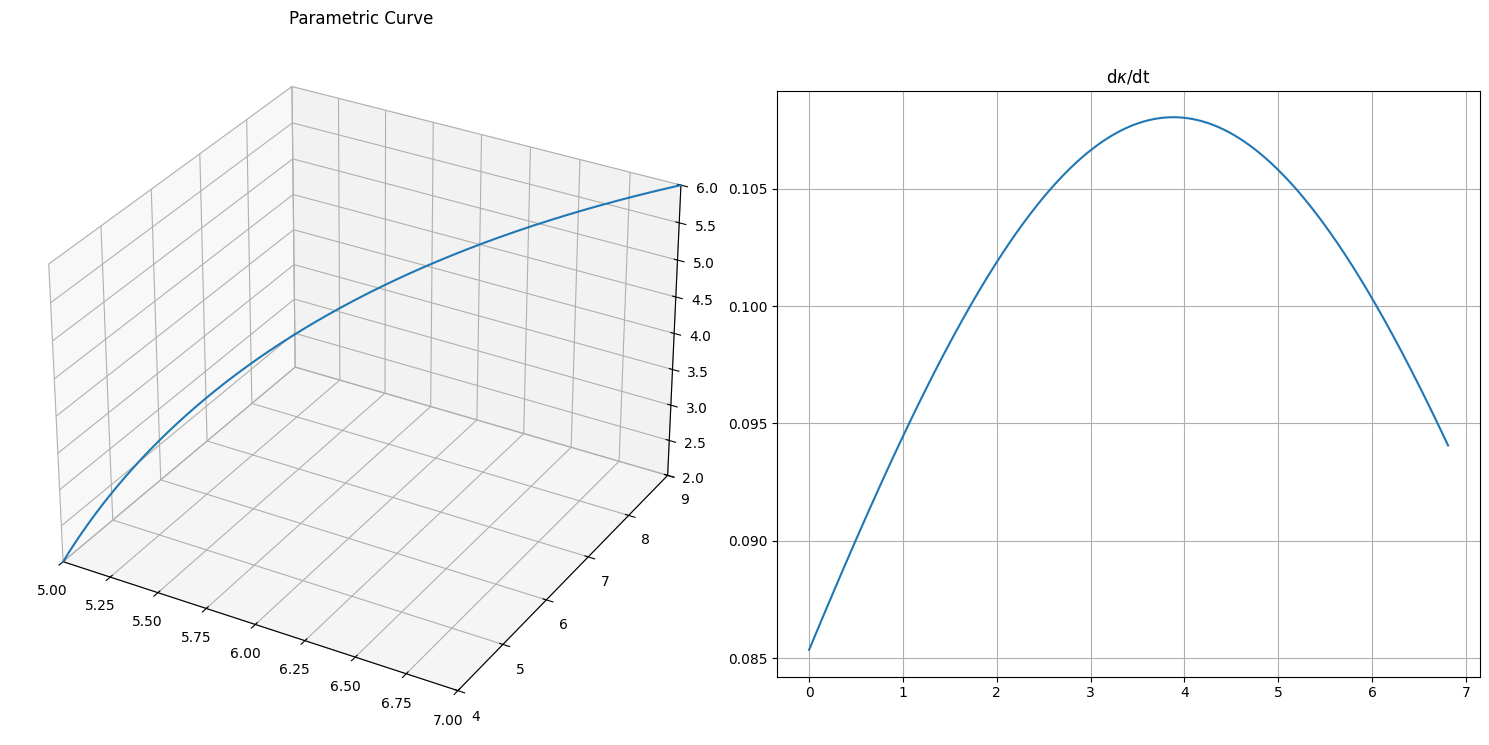

In [ ]:
"""
Cubic spline test: here is a test for the cubic spline calculation since my previous endeavours were actually quite messy (and unhelpful).
I will now apply this to the IMU sensor test.
"""
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(15,8))
ax = fig.add_subplot(121, projection='3d')


a = (5,4,2)
b = (6,7,5)
c = (7,9,6)
array = np.array([np.array(i) for i in (a,b,c)])

t = [0]
c_dist = [0]
d_dist = 0
for i in range(len(array)):
    if i == len(array)-1:
        break

    distance = np.linalg.norm(array[i+1]-array[i])
    c_dist.append(distance)
    t.append(sum(c_dist))

x = array[:, 0]
y = array[:, 1]
z = array[:, 2]

xc = CubicSpline(t,x)
yc = CubicSpline(t,y)
zc = CubicSpline(t,z)

plotting_t = np.linspace(min(t), max(t), 1000)

ax.plot(xc(plotting_t), yc(plotting_t), zc(plotting_t))

ax.set_xlim(min(xc(plotting_t)), max(xc(plotting_t)))
ax.set_ylim(min(yc(plotting_t)), max(yc(plotting_t)))
ax.set_zlim(min(zc(plotting_t)), max(zc(plotting_t)))
ax.grid()

"""
Curvature Calculations
"""
curvature_list = []
for i in range(len(plotting_t)):
    r = (xc(plotting_t[i], 0), yc(plotting_t[i], 0), zc(plotting_t[i], 0))
    r_prime = (xc(plotting_t[i], 1), yc(plotting_t[i], 1), zc(plotting_t[i], 1))
    r_double_prime = (xc(plotting_t[i], 2), yc(plotting_t[i], 2), zc(plotting_t[i], 2))

    kappa = (np.linalg.norm(np.cross(r_prime, r_double_prime)))/(np.linalg.norm(r_prime)**3)
    curvature_list.append(kappa)

ax2 = fig.add_subplot(122)
ax2.plot(plotting_t, curvature_list)
ax2.grid()
ax2.set_aspect(250)

ax.set_title("Parametric Curve")
ax2.set_title(r"d$\kappa$/dt")

plt.tight_layout()
plt.show()

**Curvature Derivation & Practice Questions**:

I want to intuitively explain what this means (understanding helps with adding additional features) so I will copy up workings out into LaTeX, make apparent any errors in my process and then apply this to the IMU code as normal.

In this derivation, review circular motion and see how it relates to this (and do practice questions on it since my physics is worsening). Try out some PAT, TMUA and MAT papers.

Once this is done, the coded aspect of my project is entirely finished off!!

----------

**Curvature Application**: Here is how I would like to apply this (*eventually it will just be machine learning but we have not gotten there yet*):

- There will be a list of the instaneous curvatures along the spline
- There will be a storage of how those curvatures change wrt time
- There will be a maximum (that is tracked (and maybe marked with a red dot))
- There may be a measure of the standard deviation of points
- There may be an average (mean/median)

*For the initial application, I will be using max($\kappa$) as it is easiest (I hope) to get working. Then, I will try to develop a pseudocode and apply updates incrementally that works towards the main goal (as written below)*:

    
    When a user wears the posture bracing, there will be a calibration phase at the beginning where there is an implied best posture. They will then do a range of exercises that will help the model "understand" what the user's spine shape is. Then, the threshold is set on the deviance away from this ideal shape.

To scaffold onto this ideal, I think it will be best to go as follows:

1. max($\kappa$)
2. how $\kappa$ changes with time; larger differences indicates big curves (if the change results in a larger value -- *this will be difficult code to make robust so maybe this won't be second*)
3. integrating across the whole spine and then dividing by the change in bounds
    



**Derivation**:
https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/curvature/v/curvature-formula-part-5

When trying to find

In [ ]:
from collections import deque
import numpy as np

deck = deque(maxlen=10)
deck.extend([3, 9, 9, 190])
d = np.mean(deck)
e = np.median(deck)
print(e)

9.0


In [ ]:
import time

t = time.time()
print(t)
time.sleep(2)
for i in range(8):
    for i in range(9):
        q = time.time()
        time.sleep(1.2)
        z = time.time()
        print(q - z)
        print(q - t)

print(t)
print(q)
print(t-q)

1757398748.8567324
-1.2001495361328125
2.0005505084991455
-1.200164794921875
3.2008249759674072
-1.2001218795776367
4.40111517906189
-1.2001044750213623
5.6013734340667725
-1.2001638412475586
6.80159854888916
-1.2001855373382568
8.001899480819702
-1.2001686096191406
9.202213764190674
-1.2001607418060303
10.402510166168213
-1.200164556503296
11.602794170379639
1757398748.8567324
1757398760.4595265
-11.602794170379639


Below is the error in the code:


    ```python
        if IMU_ID == 1:
            IMU_DEQUES[0].append(IMU_DATA_NORM)

        elif IMU_ID == 2:
            IMU_DEQUES[1].append(IMU_DATA_NORM)

        elif IMU_ID == 7:
            IMU_DEQUES[2].append(IMU_DATA_NORM)
    ```

Which means that this cannot be generalised.

All I need to do is export, through the serial and handle it, which sensor IDs are successful and place them into a list such that the improved one will be:

    ```python
    try:
        target_IMU_index = IMU_ID_LIST.index(IMU_ID)
        IMU_DEQUES[target_IMU_index].append(IMU_DATA_NORM)

    except ValueError:
        print(f"Warning: Recieved data from unknown data channel @ ID:{IMU_ID}")

    ```